In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import loo_parallel_version as loo

In [2]:
f = open('kddcup.names')
columns = f.readlines()
columns = [i.split(':')[0] for i in columns]
columns = columns[1:] + ['outcome']
f.close()

df = pd.read_csv('kddcup.data',header=None,names=columns)
df.reset_index(drop=True,inplace=True)
print(df.shape)
display(df.head())

(4898431, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
df['outcome'] = df['outcome'].apply(lambda x: x.replace('.',''))
df['binary_outcome'] = df['outcome'].apply(lambda x: 1 if x!= 'normal' else 0)

In [10]:
display(df['binary_outcome'].value_counts().to_frame())
display(df['outcome'].value_counts().to_frame())

,binary_outcome
1,3925650
0,972781


,outcome
smurf,2807886
neptune,1072017
normal,972781
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979


,dst_host_same_srv_rate
count,4.898431e+06
mean,7.537132e-01
std,4.111860e-01
min,0.000000e+00
25%,4.100000e-01
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


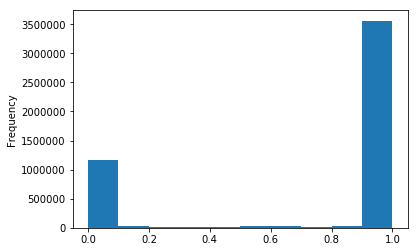

,is_host_login
count,4.898431e+06
mean,4.082940e-07
std,6.389788e-04
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+00


KeyboardInterrupt: 

In [11]:
pd.options.display.max_columns=50
for c in set(df.columns)-set(['outcome','binary_outcome']):
    if(str(df.dtypes[c]) != 'object'):
        display(df[[c]].describe())
        df[c].plot.hist()
        plt.show()
        plt.close()
    else:
        display(df[c].value_counts().to_frame())

In [4]:
# drop these low information variables
df.drop(['is_host_login','num_outbound_cmds','land'],axis=1,inplace=True)

In [5]:
exclude = ['outcome','binary_outcome']
model_vars = list(set(df.columns) - set(exclude))
loo_vars = ['service','flag']

In [6]:
kf = KFold(n_splits=10,random_state=10)
fold = 0
for train,test in kf.split(df):
    df.loc[test,'fold'] = fold
    fold +=1
del fold

df['fold'].value_counts().to_frame().sort_index()

,fold
0.0,489844
1.0,489843
2.0,489843
3.0,489843
4.0,489843
5.0,489843
6.0,489843
7.0,489843
8.0,489843
9.0,489843


In [28]:
import imp
imp.reload(loo)

<module 'loo_parallel_version' from 'E:\\jupyter_nb\\kdd1999\\loo_parallel_version.py'>

In [7]:
# cv with gradient boost
for f in range(10):
    print('make LOO')
    %time ltab = loo.loo(df=df.loc[df['fold'] != f,['binary_outcome'] + loo_vars],vars=loo_vars,yvar='binary_outcome')
    print()
    
    print('get LOO columns')
    %time loo_df = ltab.applyLookup(df=df.loc[:,['binary_outcome','fold'] + loo_vars],trainVar='fold',trainValue=[g for g in range(10) if g != f])
    print()
    
    for i in ['loo_' + i for i in loo_vars]:
        df[i] = loo_df[i]
        
    del loo_df,ltab

    display(df[['fold'] + loo_vars + [i for i in df.columns if i[:4]=='loo_']].drop_duplicates())
    
for i in df.columns:
    if i[:4] == 'loo_':
        del df[i]

make LOO
Wall time: 1.91 s

get LOO columns
Wall time: 32.2 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.010106,0.832875
1288,0.0,http,S2,0.010106,0.046875
1484,0.0,http,S1,0.010106,0.012195
2062,0.0,smtp,SF,0.017061,0.832875
2067,0.0,domain_u,SF,0.000170,0.832875
2073,0.0,auth,SF,0.405312,0.832875
2084,0.0,finger,SF,0.351989,0.832875
2105,0.0,telnet,SF,0.566551,0.832875
7393,0.0,eco_i,SF,0.804757,0.832875
7468,0.0,telnet,S1,0.566551,0.012195


make LOO
Wall time: 2.16 s

get LOO columns
Wall time: 32.4 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.005767,0.670390
1,0.0,http,SF,0.005861,0.647043
2,0.0,http,SF,0.004694,0.916593
3,0.0,http,SF,0.006185,0.737009
4,0.0,http,SF,0.005586,0.737397
5,0.0,http,SF,0.005304,0.911534
6,0.0,http,SF,0.005423,0.941938
7,0.0,http,SF,0.006074,0.865632
8,0.0,http,SF,0.005676,0.813226
9,0.0,http,SF,0.006125,0.873025


make LOO
Wall time: 2.22 s

get LOO columns
Wall time: 33.1 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.006801,0.623216
1,0.0,http,SF,0.007125,0.733918
2,0.0,http,SF,0.005213,0.867058
3,0.0,http,SF,0.005844,0.643923
4,0.0,http,SF,0.006711,0.767646
5,0.0,http,SF,0.005199,0.707268
6,0.0,http,SF,0.005043,0.656113
7,0.0,http,SF,0.006866,0.913582
8,0.0,http,SF,0.006585,0.882976
9,0.0,http,SF,0.007008,0.746670


make LOO
Wall time: 2.19 s

get LOO columns
Wall time: 32.3 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.006751,0.796922
1,0.0,http,SF,0.007105,0.811935
2,0.0,http,SF,0.006042,0.623859
3,0.0,http,SF,0.005368,0.654274
4,0.0,http,SF,0.006272,0.679076
5,0.0,http,SF,0.006302,0.721691
6,0.0,http,SF,0.005931,0.779877
7,0.0,http,SF,0.006086,0.616367
8,0.0,http,SF,0.006878,0.774063
9,0.0,http,SF,0.005669,0.726378


make LOO
Wall time: 2.15 s

get LOO columns
Wall time: 32.2 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.005407,0.667508
1,0.0,http,SF,0.005351,0.852156
2,0.0,http,SF,0.006280,0.617770
3,0.0,http,SF,0.006617,0.695557
4,0.0,http,SF,0.007631,0.860348
5,0.0,http,SF,0.006145,0.685127
6,0.0,http,SF,0.007658,0.859832
7,0.0,http,SF,0.005720,0.611989
8,0.0,http,SF,0.005605,0.604552
9,0.0,http,SF,0.006620,0.791798


make LOO
Wall time: 2.2 s

get LOO columns
Wall time: 33.5 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.006884,0.700990
1,0.0,http,SF,0.006192,0.754114
2,0.0,http,SF,0.007652,0.580792
3,0.0,http,SF,0.006570,0.741366
4,0.0,http,SF,0.006095,0.694975
5,0.0,http,SF,0.006992,0.595222
6,0.0,http,SF,0.005693,0.742851
7,0.0,http,SF,0.006097,0.823598
8,0.0,http,SF,0.007390,0.585124
9,0.0,http,SF,0.007159,0.722451


make LOO
Wall time: 1.98 s

get LOO columns
Wall time: 33.7 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.006855,0.602125
1,0.0,http,SF,0.007622,0.772925
2,0.0,http,SF,0.007101,0.839740
3,0.0,http,SF,0.006755,0.624009
4,0.0,http,SF,0.007554,0.778167
5,0.0,http,SF,0.006255,0.789530
6,0.0,http,SF,0.006723,0.672626
7,0.0,http,SF,0.006105,0.736029
8,0.0,http,SF,0.005763,0.815884
9,0.0,http,SF,0.007056,0.656173


make LOO
Wall time: 2.04 s

get LOO columns
Wall time: 34.3 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.005374,0.744729
1,0.0,http,SF,0.005663,0.847034
2,0.0,http,SF,0.004515,0.881157
3,0.0,http,SF,0.006621,0.788764
4,0.0,http,SF,0.005353,0.817718
5,0.0,http,SF,0.004909,0.865521
6,0.0,http,SF,0.006118,0.631025
7,0.0,http,SF,0.006573,0.743522
8,0.0,http,SF,0.005227,0.721293
9,0.0,http,SF,0.005702,0.705506


make LOO
Wall time: 2.02 s

get LOO columns
Wall time: 33.9 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.007471,0.596045
1,0.0,http,SF,0.005832,0.669612
2,0.0,http,SF,0.006652,0.767922
3,0.0,http,SF,0.007020,0.781595
4,0.0,http,SF,0.006858,0.699969
5,0.0,http,SF,0.005591,0.743423
6,0.0,http,SF,0.005846,0.656550
7,0.0,http,SF,0.006377,0.805144
8,0.0,http,SF,0.005680,0.752620
9,0.0,http,SF,0.005378,0.724317


make LOO
Wall time: 2.02 s

get LOO columns
Wall time: 34.1 s



,fold,service,flag,loo_service,loo_flag
0,0.0,http,SF,0.006742,0.852159
1,0.0,http,SF,0.006559,0.811157
2,0.0,http,SF,0.006457,0.638081
3,0.0,http,SF,0.007544,0.940349
4,0.0,http,SF,0.007462,0.667063
5,0.0,http,SF,0.005910,0.781736
6,0.0,http,SF,0.006623,0.634341
7,0.0,http,SF,0.005897,0.872532
8,0.0,http,SF,0.005450,0.711052
9,0.0,http,SF,0.005494,0.872661
